In [1]:
%reload_ext autoreload
%autoreload 2

In [10]:
from depsurf import BCC_OBJ_PATH, BPFObject

assert BCC_OBJ_PATH.exists(), f"Path not found: {BCC_OBJ_PATH}"
bpf = BPFObject(BCC_OBJ_PATH / "bindsnoop.bpf.o")
bpf.deps_struct
deps = bpf.deps_struct_field

deps

[   system.py:19 ] INFO: Running command: "/Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/bpftool/src/bpftool -d gen min_core_btf /sys/kernel/btf/vmlinux /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.btf /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.o"
libbpf: CO-RE relocating [68] struct user_pt_regs: found target candidate [68] struct user_pt_regs in [vmlinux]
libbpf: prog 'kprobe/inet_bind': relo #0: <byte_off> [68] struct user_pt_regs.regs[0] (0:0:0 @ offset 0)
libbpf: prog 'kprobe/inet_bind': relo #0: matching candidate #0 <byte_off> [68] struct user_pt_regs.regs[0] (0:0:0 @ offset 0)
libbpf: prog 'kprobe/inet6_bind': relo #0: <byte_off> [68] struct user_pt_regs.regs[0] (0:0:0 @ offset 0)
libbpf: prog 'kprobe/inet6_bind': relo #0: matching candidate #0 <byte_off> [68] struct user_pt_regs.regs[0] (0:0:0 @ offset 0)
libbpf: prog '.text': relo #0: <byte_off> [68] struct user_pt_regs.regs[0] (0:0:0 @ offset 0)
libbpf: prog 

CalledProcessError: Command '/Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/bpftool/src/bpftool -d gen min_core_btf /sys/kernel/btf/vmlinux /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.btf /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.o' returned non-zero exit status 234.

In [39]:
result = {}

for obj_file in sorted(BCC_OBJ_PATH.glob("*.bpf.o")):
    bpf = BPFObject(obj_file)
    result[bpf.name] = bpf.deps

[decorator.py:17 ] INFO: gen_min_btf      Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bashreadline.bpf.min.btf
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bashreadline.bpf.min.json
[decorator.py:17 ] INFO: gen_min_btf      Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.btf
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.json
[decorator.py:17 ] INFO: gen_min_btf      Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biolatency.bpf.min.btf
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biolatency.bpf.min.json


[decorator.py:17 ] INFO: gen_min_btf      Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biopattern.bpf.min.btf
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biopattern.bpf.min.json
[decorator.py:17 ] INFO: gen_min_btf      Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biosnoop.bpf.min.btf
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biosnoop.bpf.min.json
[decorator.py:17 ] INFO: gen_min_btf      Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biostacks.bpf.min.btf
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biostacks.bpf.min.json
[decorator.py:17 ] INFO: gen_min_btf      Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/biotop.bpf.min.btf
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tool

In [5]:
from depsurf import BuildVersion

versions = BuildVersion.filter()

In [33]:
from collections import defaultdict

import pandas as pd
from depsurf import Causes, DepKind
from depsurf.plot import setup_pandas


counts = {}
cause_state = defaultdict(dict)
cause_delta = defaultdict(dict)
for prog_name, deps in result.items():
    for kind, name in deps:
        if kind not in (DepKind.STRUCT, DepKind.FUNC, DepKind.TRACEPOINT, DepKind.LSM):
            continue

        if kind == DepKind.STRUCT and name == "user_pt_regs":
            continue

        if kind == DepKind.FUNC and (name.startswith("dummy") or name == "foo"):
            continue

        key = (prog_name, kind, name)

        for v in versions:
            cause_state[v][key] = kind.is_available(v.img, name)

        for v1, v2 in zip(versions, versions[1:]):
            cause_delta[(v1, v2)][key] = kind.is_changed(v1.img, v2.img, name)

    df = pd.DataFrame(deps)
    count = df.groupby(0).count().T
    counts[prog_name] = count


df_delta = pd.DataFrame(cause_delta)
df_delta = df_delta.replace({True: "❌", False: "-", None: ""})
df_delta.columns = [
    f"{v1.short_version} {v2.short_version}" for v1, v2 in df_delta.columns
]
df_delta = df_delta[(df_delta != "-").any(axis=1)]
df_delta.index.names = ["Program", "Type", "Name"]
df_delta

4.4 4.8 4.8 4.10 4.10 4.13 4.13 4.15 4.15 4.18 4.18 5.0 5.0 5.3 5.3 5.4 5.4 5.8 5.8 5.11 5.11 5.13 5.13 5.15 5.15 5.19 5.19 6.2 6.2 6.5 6.5 6.8
Program     Type       Name                                                                                                                                                                               
bindsnoop   Struct     sock                                      ❌        ❌         ❌         ❌         ❌        ❌       ❌       -       ❌        ❌         -         ❌         ❌        ❌       ❌       ❌
                       sock_common                               ❌        -         ❌         -         -        ❌       -       -       -        -         -         -         -        -       -       -
                       socket                                    -        -         -         -         -        -       ❌       -       -        -         -         -         -        -       -       -
                       inet_sock                                 -        -         ❌         -         -        -       -       -       -        ❌         -         ❌         -        -       ❌       ❌
biolatency  Tracepoint block_rq_complete                         -        -         ❌         -         -        -       -       -       -        -         -         -         ❌        -       -       -
                       block_rq_insert                           -        -         -         -         -        -       -       -       -        ❌         -         -         -        -       -       -
                       block_rq_issue                            -        -         -         -         -        -       -       -       -        ❌         -         -         -        -       -       -
            Struct     gendisk                                   ❌        -         -         ❌         ❌        -       ❌       -       ❌        ❌         ❌         ❌         -        ❌       ❌       -
                       request_queue                             ❌        ❌         ❌         ❌         ❌        ❌       ❌       ❌       ❌        ❌         ❌         ❌         ❌        ❌       ❌       -
                       request                                   ❌        ❌         ❌         ❌         ❌        ❌       ❌       ❌       ❌        ❌         ❌         -         ❌        ❌       ❌       ❌
biopattern  Tracepoint block_rq_complete                         -        -         ❌         -         -        -       -       -       -        -         -         -         ❌        -       -       -
            Struct     trace_event_raw_block_rq_completion                                                                                                                               -       -       -
biosnoop    Function   blk_account_io_merge_bio                                                                                                   -         -         -         -        -       -       -
                       blk_account_io_start                      -        -         -         -         -        -       -       -       ❌        -         -         -                                   
            Tracepoint block_io_start                                                                                                                                                                    -
                       block_rq_complete                         -        -         ❌         -         -        -       -       -       -        -         -         -         ❌        -       -       -
                       block_rq_insert                           -        -         -         -         -        -       -       -       -        ❌         -         -         -        -       -       -
                       block_rq_issue                            -        -         -         -         -        -       -       -       -        ❌         -         -         -        -       -       -

In [31]:
df_state = pd.DataFrame(cause_state)
df_state.columns = [v.short_version for v in df_state.columns]
df_state = df_state.replace({True: "✅", False: "❌"})
df_state

4.4 4.8 4.10 4.13 4.15 4.18 5.0 5.3 5.4 5.8 5.11 5.13 5.15 5.19 6.2 6.5 6.8
bindsnoop   Function   inet6_bind                            ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       inet_bind                             ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
            Struct     sock                                  ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       sock_common                           ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       in6_addr                              ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       socket                                ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       inet_sock                             ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
biolatency  Tracepoint block_rq_complete                     ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       block_rq_insert                       ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       block_rq_issue                        ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
            Struct     gendisk                               ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       request_queue                         ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       request                               ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
biopattern  Tracepoint block_rq_complete                     ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
            Struct     trace_event_raw_block_rq_completion   ❌   ❌    ❌    ❌    ❌    ❌   ❌   ❌   ❌   ❌    ❌    ❌    ❌    ✅   ✅   ✅   ✅
biosnoop    Function   blk_account_io_merge_bio              ❌   ❌    ❌    ❌    ❌    ❌   ❌   ❌   ❌   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       blk_account_io_start                  ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ❌   ❌   ❌   ❌
            Tracepoint block_io_start                        ❌   ❌    ❌    ❌    ❌    ❌   ❌   ❌   ❌   ❌    ❌    ❌    ❌    ❌   ❌   ✅   ✅
                       block_rq_complete                     ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       block_rq_insert                       ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       block_rq_issue                        ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
            Struct     gendisk                               ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       request_queue                         ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       request                               ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
biostacks   Function   blk_account_io_done                   ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ❌   ❌   ✅   ✅
                       blk_account_io_merge_bio              ❌   ❌    ❌    ❌    ❌    ❌   ❌   ❌   ❌   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅
                       blk_account_io_start                  ✅   ✅    ✅    ✅    ✅    ✅   ✅   ✅   ✅   ✅    ✅    ✅    ✅    ❌   ❌   ❌   ❌
            Tracepoint block_io_done                         ❌   ❌    ❌    ❌    ❌    ❌   ❌   ❌   ❌   ❌    ❌    ❌    ❌    ❌   ❌   ✅   ✅
                       block_io_start                        ❌   ❌    ❌    ❌    ❌    ❌   ❌   ❌   ❌   ❌    ❌    ❌    ❌    ❌   ❌   ✅   ✅
         

In [30]:
df_counts = pd.concat(counts, axis=0).fillna(0).astype(int)
df_counts.index = df_counts.index.droplevel(-1)
df_counts

,Struct,uprobe,Function,Tracepoint,Perf Event,Syscall,USDT
bashreadline,1,1,0,0,0,0,0
bindsnoop,6,0,2,0,0,0,0
biolatency,3,0,0,3,0,0,0
biopattern,1,0,0,1,0,0,0
biosnoop,4,0,2,4,0,0,0
biostacks,4,0,3,2,0,0,0
biotop,4,0,5,2,0,0,0
bitesize,3,0,0,1,0,0,0
cachestat,0,0,5,2,0,0,0
capable,1,0,1,0,0,0,0


<Axes: >

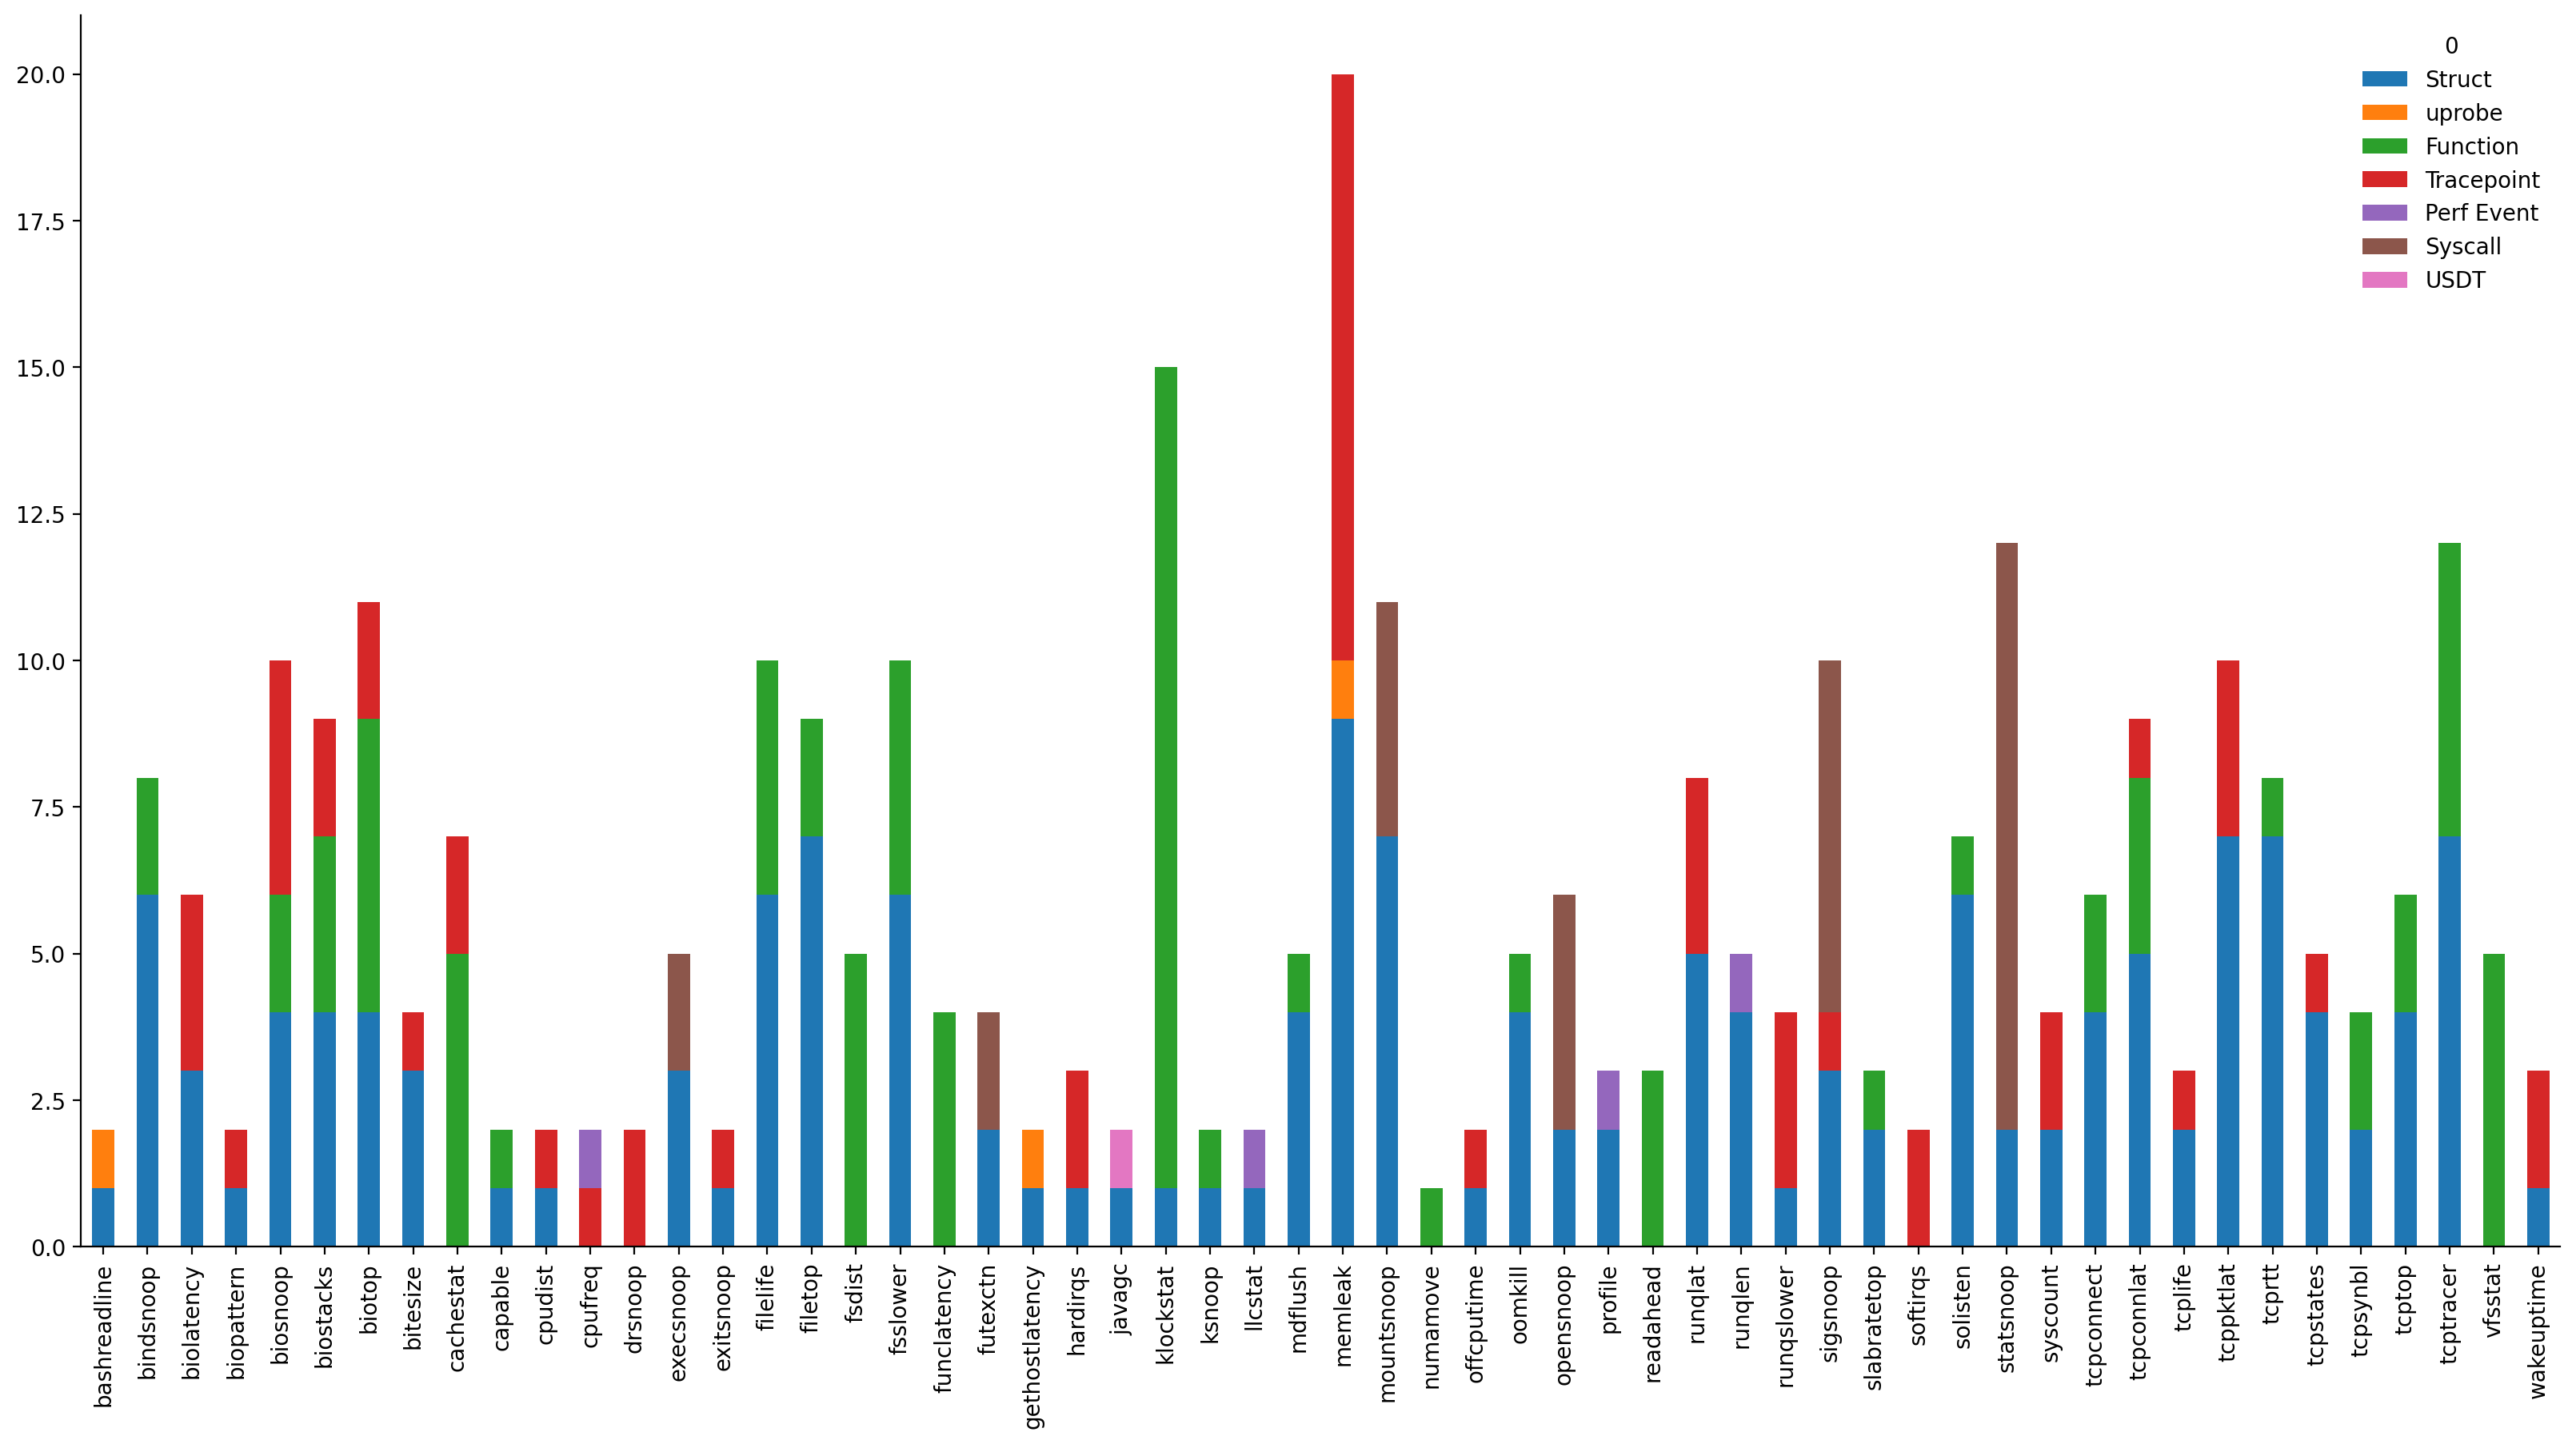

In [9]:
# plot df_counts

import matplotlib.pyplot as plt

df_counts.plot(kind="bar", stacked=True, figsize=(20, 10))

In [10]:
import pandas as pd

from depsurf import category_map

df = pd.DataFrame(scores)
df = df.sort_values("score", ascending=False)
df["category"] = df.name.map(lambda x: category_map[x].value)
df = df[df.score > 0]
df

NameError: name 'scores' is not defined

In [ ]:
import matplotlib.pyplot as plt
from depsurf import Category

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

# remove margin for the bar plot
plt.margins(x=0.01)

curr_x = 0
for category, cat_df in df.groupby("category"):
    color = Category(category).color
    ax.bar(cat_df.name, cat_df["score"], color=color, label=category)
    xlen = len(cat_df) / len(df)
    ax.axhline(
        cat_df["score"].mean(),
        linestyle="--",
        xmin=curr_x,
        xmax=curr_x + xlen,
        color="black",
        linewidth=1,
    )
    curr_x += xlen


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("right")

ax.set_ylabel("Unstable Score")
ax.set_xlabel("File")
ax.set_title("Unstable Score of BPF Programs (lower is better)")